<a href="https://colab.research.google.com/github/AvantiShri/oceanography_colab_notebooks/blob/master/for_rian/Overlay_GLODAP_GP15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py_pcha
!pip install gsw

     |████████████████████████████████| 2.4MB 2.8MB/s 


Grab the data

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1O869bUhoTrPCW4hDaSVswLiQ7vzhzIlP' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2020-10-01 00:44:26--  https://docs.google.com/uc?export=download&id=1O869bUhoTrPCW4hDaSVswLiQ7vzhzIlP
Resolving docs.google.com (docs.google.com)... 173.194.217.113, 173.194.217.101, 173.194.217.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.217.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cs7tm6j6b2bmd48ucea3cf0lo71qq8er/1601513025000/06203730782251856755/*/1O869bUhoTrPCW4hDaSVswLiQ7vzhzIlP?e=download [following]
--2020-10-01 00:44:26--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cs7tm6j6b2bmd48ucea3cf0lo71qq8er/1601513025000/06203730782251856755/*/1O869bUhoTrPCW4hDaSVswLiQ7vzhzIlP?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

In [41]:

ROUNDING_PRECISION = 4

#For some reason, altair chokes when provided data frames with some
# of the original column names. So I am remapping the column names.
def remap_colnames(df, colnames_map):
  remapnames_df = pandas.DataFrame(dict([
      (new_col, np.array(df[orig_col]))
      for new_col,orig_col in colnames_map.items()]))
  return remapnames_df


def read_glodap():
  df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv", na_values = -9999)
  #, sep='delimiter',header=None
  df = remap_colnames(df=df,
                      colnames_map={'latitude (degrees)':"latitude",
                                    'longitude (degrees)':"longitude",
                                    'year':"year",
                                    'depth (m)':"depth",
                                    'pressure (dbar)':"pressure",
                                    'temperature(degrees C)':"temperature",
                                    'salinity (psu)':"salinity",
                                    'oxygen (umol/kg)':"oxygen",
                                    'silicate (umol/kg)':"silicate",
                                    'nitrate (umol/kg)':"nitrate",
                                    'phosphate (umol/kg)':"phosphate",
                                    'potential density':"sigma0",
                                  })
  print("# examples in glodap:", len(df))
  SALINITY_MINIMUM = 30
  print("Examples below the salinity minimum:",
        np.sum(df['salinity (psu)'] < SALINITY_MINIMUM))
  #Drop rows that have outlier values for the salinity. Note, this will also
  # drop rows that have nan values for the salinity.
  df = pandas.DataFrame(
        df[df['salinity (psu)'] >= SALINITY_MINIMUM])
  #create a column for calculated variables
  df['NO'] = df['oxygen (umol/kg)'] + (df['nitrate (umol/kg)']*9.68)
  df['PO'] = df['oxygen (umol/kg)'] + (df['phosphate (umol/kg)']*155)
  df['pt'] = np.round(
      gsw.pt_from_t(df['salinity (psu)'],
                    df['temperature(degrees C)'],
                    df['pressure (dbar)'],
                    df['potential density']),
    decimals=ROUNDING_PRECISION)
  return df


def read_gp15():
  #Easy remapping of the column names
  df = pandas.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv", na_values = -999)
  df.columns
  #, sep='delimiter',header=None
  df = remap_colnames(df=df, colnames_map={
              'Station number':"stnnbr",
              'GEOTRACES ID':"geotrc_ID",
              'latitude (degrees)':"lat",
              'longitude (degrees)':"lon",
              'depth (m)':"depth",
              'pressure (dbar)':"pres",
              'temperature(degrees C)':"t",
              'salinity (psu)':"SP",
              'oxygen (umol/kg)':"O2",
              'silicate (umol/kg)':"Si",
              'nitrate (umol/kg)':"NO3",
              'phosphate (umol/kg)':"PO4",
              'potential density':"sig0",
              'PO (umol/kg)':"PO",
              })
  #create a column for calculated variables
  df['NO'] = df['oxygen (umol/kg)'] + (df['nitrate (umol/kg)']*9.68)
  df['pt'] = gsw.pt_from_t(df['salinity (psu)'],
                           df['temperature(degrees C)'],
                           df['pressure (dbar)'],
                           df['potential density'])
  return df


glodap_dataset = read_glodap()
gp15_dataset = read_gp15()

# examples in glodap: 452744
Examples below the salinity minimum: 104


Read in the data frame and rename the columns

In [18]:
import altair as alt

CHART_WIDTH=400
CHART_HEIGHT=200
FONTSIZE=10


#convenience functions to turn off default altair behaviour of including
# zero in the axis even if no points are at 0
def nozero_xaxis(field_name):
  return alt.X(field_name, scale=alt.Scale(zero=False))

def nozero_yaxis(field_name, domain=None):
  if (domain is None):
    return alt.Y(field_name, scale=alt.Scale(zero=False))
  else:
    return alt.Y(field_name, scale=alt.Scale(zero=False, domain=domain))

interval_selection = alt.selection_interval()
color = alt.condition(interval_selection, alt.value('blue'), alt.value('lightgray'))

tooltip_columns = (
    ['latitude (degrees)', 'longitude (degrees)', 'depth (m)'])

#base chart for displaying the observed points
basechart = alt.Chart(gp15_dataset).mark_point(opacity=0.3).encode(
  color=color,
  tooltip=tooltip_columns
).properties(width=CHART_WIDTH,
             height=CHART_HEIGHT
).add_selection(interval_selection)


def create_scatter(xaxis, yaxis):
  return basechart.encode(nozero_xaxis(xaxis), nozero_yaxis(yaxis))
  #return archetype_basechart.encode(nozero_xaxis(xaxis), nozero_yaxis(yaxis))


#compose the whole layout
alt.vconcat(
(create_scatter('pt','salinity (psu)')
| create_scatter('salinity (psu)', 'silicate (umol/kg)')
| create_scatter('pt','silicate (umol/kg)')),

(create_scatter('pt','NO')
| create_scatter('salinity (psu)', 'NO')
| create_scatter('silicate (umol/kg)','NO')),
 
(create_scatter('pt','PO (umol/kg)')
| create_scatter('salinity (psu)', 'PO (umol/kg)')
| create_scatter('NO', 'PO (umol/kg)')),

(basechart.encode(nozero_xaxis('latitude (degrees)'),
                  nozero_yaxis('depth (m)', domain=(6000, 0))))

).configure_axis(labelFontSize=FONTSIZE,
                 titleFontSize=FONTSIZE)#.properties(padding=0, spacing=0)
# the padding/spacing doesn't propagate to subcharts propertly


alt.VConcatChart(...)

In [68]:
minty_northern_glodap = glodap_dataset[((glodap_dataset["pt"] < 5)
& (glodap_dataset["salinity (psu)"] < 34)
& (glodap_dataset["latitude (degrees)"] > 50) )]
print("Number of minty northern points:", len(minty_northern_glodap))

Number of minty northern points: 3672


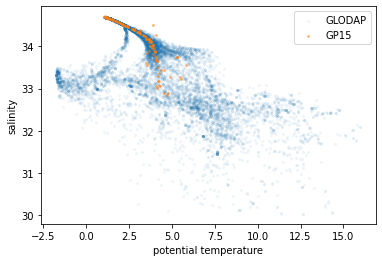

In [81]:
northern_glodap = glodap_dataset[(glodap_dataset["latitude (degrees)"] > 50)]
northern_gp15 = gp15_dataset[(gp15_dataset["latitude (degrees)"] > 50)]

handles = []
handles.append(
    plt.scatter(northern_glodap["pt"], northern_glodap["salinity (psu)"],
                alpha=0.05, s=3))
handles.append(
    plt.scatter(northern_gp15["pt"], northern_gp15["salinity (psu)"],
                alpha=0.5, s=3))
plt.legend(handles, ["GLODAP", "GP15"])
plt.xlabel("potential temperature")
plt.ylabel("salinity")
plt.show()

In [62]:
len(northern_glodap)

13684